# Visualization

In [1]:
import sys
import pathlib

In [2]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from shapely import affinity
import contextily as cx
import geopandas as gpd
from shapely.geometry import Point, LineString
import matplotlib.image as mpimg
from PIL import Image
from scipy import ndimage

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
sys.path.append("..")

In [5]:
from src.trajectory import point_to_bbox
from src.utils import WorldDefinition
from src.preprocess import transform_df_to_trajectory_gdf

## Read data

In [6]:
data_path = "../data/raw/rdb1.parquet"

In [7]:
df = pd.read_parquet(data_path)

In [8]:
df = df[df["table"] == "rdb1_1"]

In [9]:
df.head()

,index,ID,TIMESTAMP,OBJID,UTM_X,UTM_Y,UTM_ANGLE,V,ACC,ACC_LAT,ACC_TAN,CLASS,WIDTH,LENGTH,table
0,0,1,0.000000,1,619302.33,5809133.78,0.453485,4.74,0.1415,-0.1201,0.0747,Heavy Vehicle,2.7892,6.0217,rdb1_1
1,1,2,0.033367,1,619302.47,5809133.85,0.452985,4.75,0.1341,-0.1156,0.0679,Heavy Vehicle,2.7892,6.0217,rdb1_1
2,2,3,0.066733,1,619302.61,5809133.91,0.452485,4.75,0.1316,-0.1063,0.0776,Heavy Vehicle,2.7892,6.0217,rdb1_1
3,3,4,0.100100,1,619302.76,5809133.98,0.451985,4.75,0.1368,-0.0920,0.1013,Heavy Vehicle,2.7892,6.0217,rdb1_1
4,4,5,0.133467,1,619302.90,5809134.05,0.451485,4.76,0.1568,-0.0729,0.1388,Heavy Vehicle,2.7892,6.0217,rdb1_1


## Read traffic lanes

In [22]:
trafficlanes_shapefile = pathlib.Path("../data/raw/rdb1/map_rdb1/shapefiles_trafficlanes")
trafficlanes = gpd.read_file(trafficlanes_shapefile)

## Visualize multiple traces

Turn each object trace into into a line string

In [10]:
gdf_traces = transform_df_to_trajectory_gdf(df)

Plot all traces in one image

<AxesSubplot:>

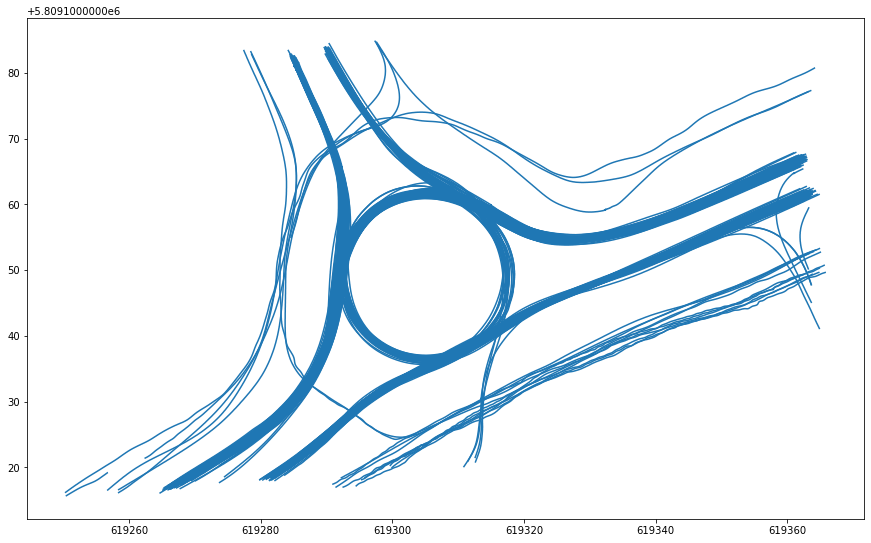

In [11]:
fig, ax = plt.subplots(figsize=(15, 10))
gdf_traces.plot(ax=ax)

### Class

Plot traces per class

In [13]:
gdf_traces["CLASS"].value_counts()

Car               295
Medium Vehicle     28
Pedestrian         10
Bicycle             9
Trailer             5
Bus                 4
Heavy Vehicle       3
Motorcycle          2
Name: CLASS, dtype: int64

In [14]:
color_cycler = plt.rcParams['axes.prop_cycle']

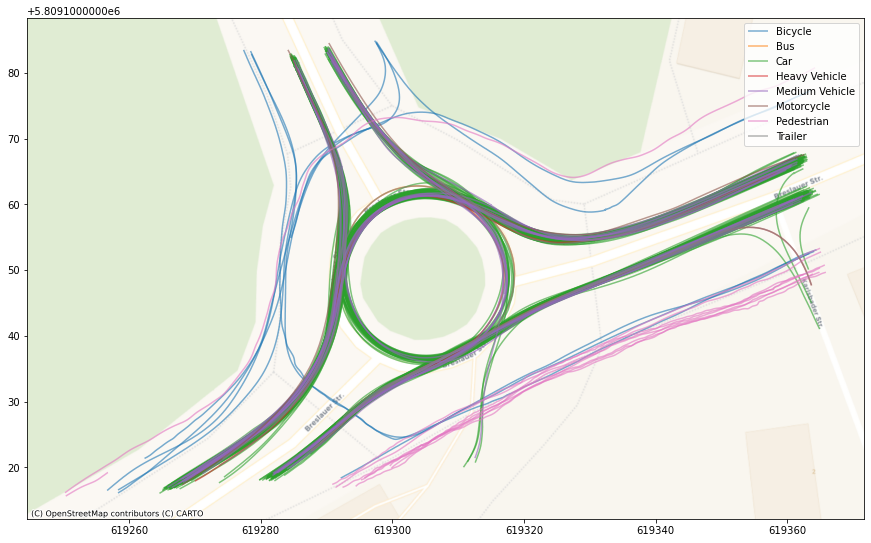

In [17]:
fig, ax = plt.subplots(figsize=(15, 10))
for (class_name, group), c in zip(gdf_traces.groupby("CLASS"), color_cycler):
    group.plot(ax=ax, label=class_name, color=c["color"], alpha=0.6)
cx.add_basemap(ax, crs=gdf_traces.crs.to_string(), source=cx.providers.CartoDB.Voyager, zoom="auto")
ax.legend()

### Motorized vehicles

In [19]:
gdf_traces_vehicle = gdf_traces[gdf_traces["CLASS"].isin(["Bus", "Car", "Medium Vehicle", "Heavy Vehicle", "Motorcycle"])]

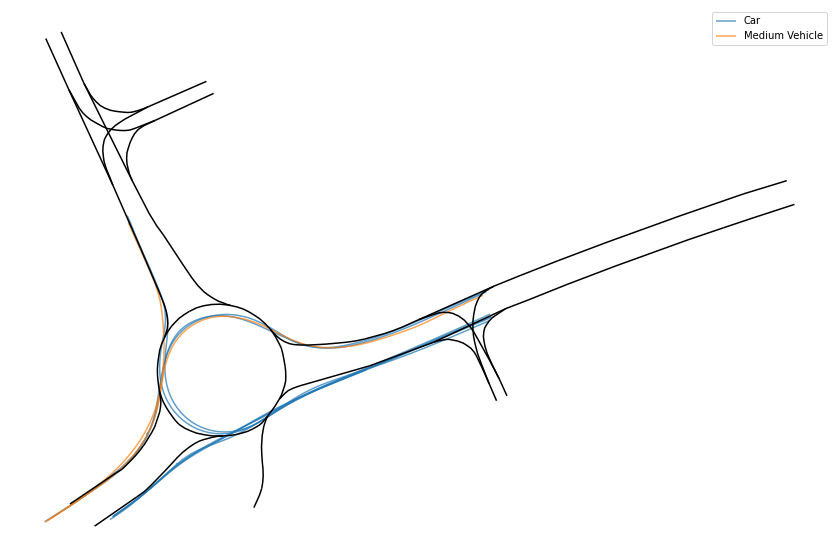

In [25]:
fig, ax = plt.subplots(figsize=(15, 10))
for (class_name, group), c in zip(gdf_traces_vehicle.sample(10).groupby("CLASS"), color_cycler):
    group.plot(ax=ax, label=class_name, color=c["color"], alpha=0.7)
trafficlanes.plot(ax=ax, color="k")
# cx.add_basemap(ax, crs=gdf_traces_vehicle.crs.to_string(), source=cx.providers.CartoDB.Voyager, zoom="auto")
ax.legend()
ax.set_axis_off()

## Visualize shapefiles

In [ ]:
trafficlanes_shapefile = pathlib.Path("../data/raw/rdb1/map_rdb1/shapefiles_trafficlanes")
trafficlanes = gpd.read_file(trafficlanes_shapefile)

In [ ]:
trafficlanes.head()

In [ ]:
drivable_shapefile = pathlib.Path("../data/raw/rdb1/map_rdb1/shapefiles_drivableareas")
drivable = gpd.read_file(drivable_shapefile)

In [ ]:
drivable

## Visualize single timestamp

### Without map

In [ ]:
# 'nearest' interpolation strategy
df["k"] = (df["TIMESTAMP"]*1000 / 33.333).round().astype(int)

In [ ]:
df_t = df[(df["k"] == 5001) & (df["table"] == "rdb1_2")]

In [ ]:
gdf_t = gpd.GeoDataFrame(
    df_t, geometry=gpd.points_from_xy(df_t["UTM_X"], df_t["UTM_Y"]), crs='EPSG:25832')

In [ ]:
gdf_t["bbox"] = gdf_t.apply(lambda row: point_to_bbox(row.geometry, row["WIDTH"], row["LENGTH"], row["UTM_ANGLE"]), axis=1)

In [ ]:
gdf_t["bbox"]  = gdf_t.set_geometry("bbox").boundary

In [ ]:
gdf_t.head()

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))
trafficlanes.plot(ax=ax, color="k")
# drivable.plot(ax=ax, color="g")
gdf_t.set_geometry("bbox").plot(ax=ax, column="CLASS")

In [ ]:
background_image = mpimg.imread(r'..\data\raw\rdb1\geo-referenced_images_rdb1\rdb1.png')

In [ ]:
plt.figure(figsize=(15,5))
plt.imshow(background_image)
plt.axis("off")

In [ ]:
background_image.shape[1]/background_image.shape[0]

In [ ]:
world_def = WorldDefinition.from_pgw_file(pathlib.Path(r'..\data\raw\rdb1\geo-referenced_images_rdb1\rdb1.pgw'))

In [ ]:
world_def

In [ ]:
world_def._get_affine_matrix()

In [ ]:
extent = world_def.get_image_extent(3840, 2160)

In [ ]:
extent

In [ ]:
w, h = extent[1] - extent[0], extent[3] - extent[2]
w, h

In [ ]:
w/h

In [ ]:
background_image.shape[1]/background_image.shape[0]

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.imshow(background_image, extent=extent, origin="upper", aspect="auto")
gdf_t.set_geometry("bbox").plot(ax=ax)

# cx.add_basemap(ax, crs=df_traces_vehicle.crs.to_string(), source=cx.providers.CartoDB.Voyager, zoom="auto")